<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>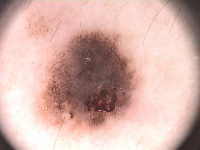</td><td>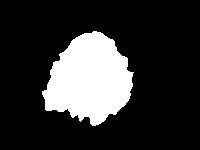</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!pip install googledrivedownloader

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
from torchvision import transforms


size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np


X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

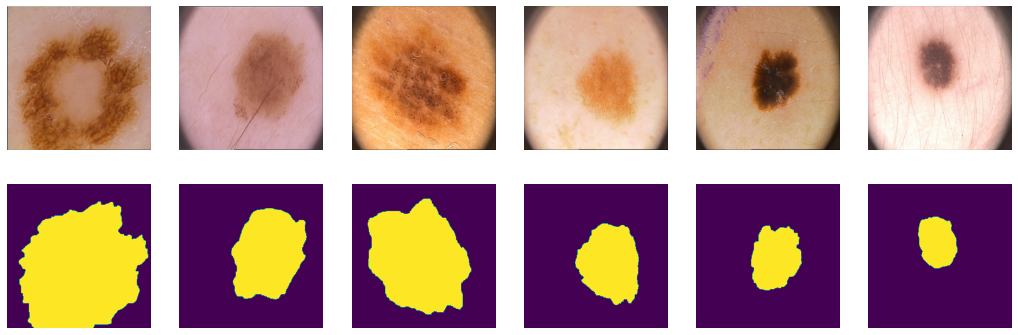

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class LesionsDataset(Dataset):
    def __init__(self, data, target, train_transforms=None, mode='train'):
        super().__init__()
        self.mode = mode
        self.data = data
        self.target = target
        self.len_ = data.shape[0]
        self.transforms = train_transforms

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        item = [self.data[index], self.target[index]]

        if self.mode == 'train' and self.transforms:
            item[0] = self.transforms(item[0])
        else:
            item[0] = transforms.ToTensor()(item[0])

        item[1] = transforms.ToTensor()(item[1])

        return item[0], item[1]

In [13]:
batch_size = 10

train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.ColorJitter(brightness=0.25, saturation=0.25, contrast=0.25),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5)
])
# np.rollaxis(X[ts], 3, 1)
tr_dataset = LesionsDataset(X[tr], np.expand_dims(Y[tr], -1), 
                            train_transforms, 'train')
val_dataset = LesionsDataset(X[val], np.expand_dims(Y[val], -1), 
                             mode='val')
ts_dataset = LesionsDataset(X[ts], np.expand_dims(Y[ts], -1), 
                             mode='test')

data_tr = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
data_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
data_ts = DataLoader(ts_dataset, batch_size=batch_size, shuffle=False)

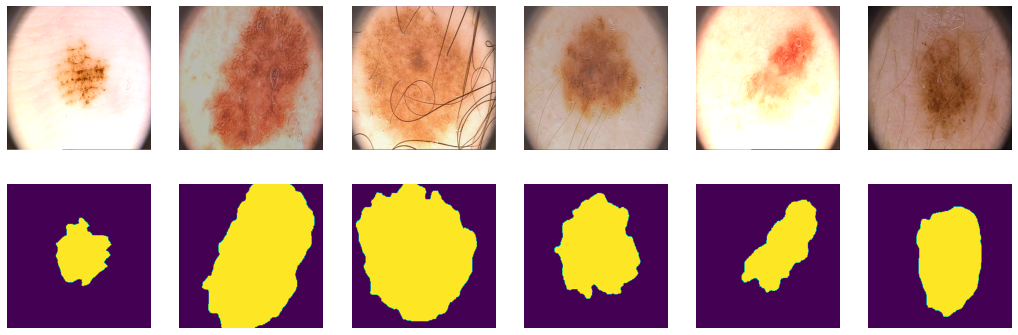

In [14]:
data = next(iter(data_tr))
images_to_print = data[0][:6]
targets = data[1][:6]

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    img = images_to_print[i].numpy()
    img = np.transpose(img, axes=(1, 2, 0))
    plt.imshow(img)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(targets[i].numpy()[0])
plt.show();

In [15]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

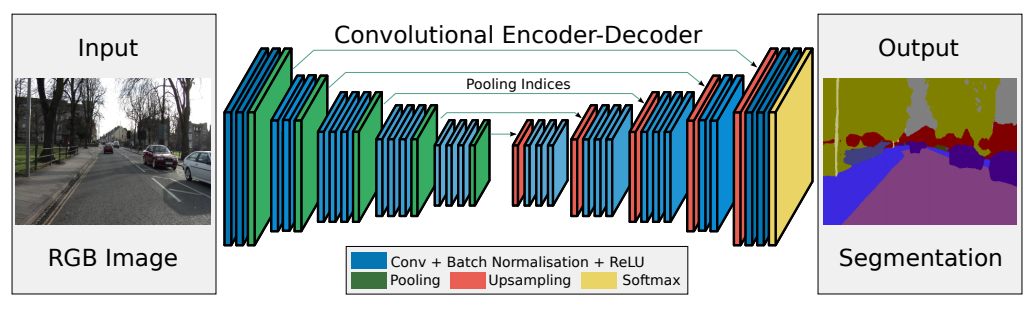

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [18]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True), 
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True), 
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True), 
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                      stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample0 = nn.MaxUnpool2d(kernel_size=2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, 
                      padding=1, bias=False), 
        )

    def forward(self, x):
        # encoder
        x, i0 = self.pool0(self.enc_conv0(x))
        x, i1 = self.pool1(self.enc_conv1(x))
        x, i2 = self.pool2(self.enc_conv2(x))
        x, i3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample3(x, i3)
        x = self.upsample2(self.dec_conv3(x), i2)
        x = self.upsample1(self.dec_conv2(x), i1)
        x = self.upsample0(self.dec_conv1(x), i0)
        x = self.dec_conv0(x)

        del i0, i1, i2, i3
        torch.cuda.empty_cache()

        return x

In [19]:
segnet = SegNet().to(device)
summary(segnet, input_size=(3, 256, 256), batch_size=10, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 256, 256]           1,728
       BatchNorm2d-2         [10, 64, 256, 256]             128
         LeakyReLU-3         [10, 64, 256, 256]               0
            Conv2d-4         [10, 64, 256, 256]          36,864
       BatchNorm2d-5         [10, 64, 256, 256]             128
         LeakyReLU-6         [10, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [10, 128, 128, 128]          73,728
       BatchNorm2d-9        [10, 128, 128, 128]             256
        LeakyReLU-10        [10, 128, 128, 128]               0
           Conv2d-11        [10, 128, 128, 128]         147,456
      BatchNorm2d-12        [10, 128, 128, 128]             256
        LeakyReLU-13        [10, 128, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [20]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [21]:
def bce_loss(y_pred, y_real):
    #pos_y_pred = torch.clamp(y_pred, min=0)
    #abs_y_pred = torch.abs(y_pred)

    res = -torch.multiply(y_real, y_pred)
    tmp_res = torch.logaddexp(torch.Tensor([0]).to(device), -y_pred)

    res += y_pred
    res += tmp_res
    
    return torch.mean(res)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [22]:
def predict_to_batch(output, threshold=0.5):
    return torch.sigmoid(output) >= threshold

In [23]:
def score_model_on_batch(metric, output, Y_batch):
    Y_pred = predict_to_batch(output)
    score = metric(Y_pred, Y_batch).mean().item()
    return score


def score_model(model, metric, data):
    scores = 0
    model.eval()

    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)

        with torch.no_grad():
            output = model.forward(X_batch)
            scores += score_model_on_batch(metric, output, Y_label)

    return scores / len(data)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [44]:
def train_loop(model, opt, loss_fn, data_tr, verbose, metric):
    avg_loss, avg_quality = 0, 0

    for X_batch, Y_batch in data_tr:
        model.train()
        # data to device
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        # set parameter gradients to zero
        opt.zero_grad()
        # forward
        output = model.forward(X_batch)
        loss = loss_fn(output, Y_batch) # forward-pass
        loss.backward()  # backward-pass
        opt.step()  # update weights

        # calculate loss and accuracy to show the user
        avg_loss += loss.item() / len(data_tr)
        if verbose:
            model.eval()
            quality = score_model_on_batch(metric, output, Y_batch)
            avg_quality += quality / len(data_tr)

    return avg_loss, avg_quality

In [25]:
def val_loop(model, loss_fn, data_val, verbose, metric):
    avg_loss, avg_quality = 0, 0
    model.eval()

    for X_batch, Y_batch in data_val:
        # data to device
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        # Disable gradients computation
        with torch.no_grad():
            # forward
            output = model.forward(X_batch)
            loss = loss_fn(output, Y_batch) # forward-pass

        if verbose:
            quality = score_model_on_batch(metric, output, Y_batch)
            avg_quality += quality / len(data_val)

        # calculate loss and accuracy to show the user
        avg_loss += loss.item() / len(data_val)

    return avg_loss, avg_quality

In [45]:
def plot_intermediate_result(X_batch, y_pred, train_loss, epoch, epochs):
    clear_output(wait=True)
    for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X_batch[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(y_pred[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - train loss: %f' % (epoch+1, epochs, train_loss))
    plt.show()

In [43]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, verbose=False, 
          metric=iou_pytorch):
    tr_losses, tr_quality = [], []
    val_losses, val_quality = [], []
    X_val, _ = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        ep_tr_loss, ep_tr_quality = train_loop(model, opt, loss_fn, data_tr, 
                                               verbose, metric)

        ep_val_loss, ep_val_quality = val_loop(model, loss_fn, data_val, 
                                               verbose, metric)
        
        tr_losses.append(ep_tr_loss)
        val_losses.append(ep_val_loss)

        if verbose:
            tr_quality.append(ep_tr_quality)
            val_quality.append(ep_val_quality)
            
        # show intermediate results
        with torch.no_grad():
            model.eval()
            Y_hat = model.forward(X_val.to(device)).cpu()

        plot_intermediate_result(X_val, Y_hat, ep_tr_loss, epoch, epochs)

    if verbose:
        return tr_losses, val_losses, tr_quality, val_quality
    else:
        return tr_losses, val_losses

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


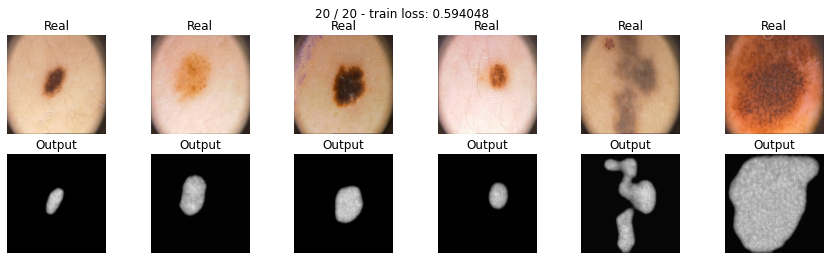

In [ ]:
bce_segnet = SegNet().to(device)
max_epochs = 20
bce_optimizer = optim.Adam(bce_segnet.parameters(), lr=0.0003)
tr_losses, val_losses, tr_quality, val_quality = train(bce_segnet, 
                                                       bce_optimizer, 
                                                       bce_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
score_model(bce_segnet, iou_pytorch, data_ts)

0.781438148021698

In [28]:
def save_train_info(filename, tr_losses, val_losses, tr_quality, val_quality):
    with open(filename, "w") as file_obj:
        file_obj.write("Train loss:\n")
        file_obj.write(" ".join([str(x) for x in tr_losses]))
        file_obj.write("\n")

        file_obj.write("Val loss:\n")
        file_obj.write(" ".join([str(x) for x in val_losses]))
        file_obj.write("\n")

        file_obj.write("Train acc:\n")
        file_obj.write(" ".join([str(x) for x in tr_quality]))
        file_obj.write("\n")

        file_obj.write("Val acc:\n")
        file_obj.write(" ".join([str(x) for x in val_quality]))
        file_obj.write("\n")

In [ ]:
save_train_info("bce_segnet_log.txt", tr_losses, val_losses, tr_quality, 
                val_quality)
#save_checkpoint("/content/segnet_state", bce_segnet, optimizer)

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [58]:
def dice_loss(y_pred, y_real):
    SMOOTH = 1
    y_pred = torch.sigmoid(y_pred)

    num = torch.sum(2 * y_real * y_pred)
    den = torch.sum(y_real) + torch.sum(y_pred)
    res = 1 - (num + SMOOTH) / (den + SMOOTH)
    
    return res

Проводим тестирование:

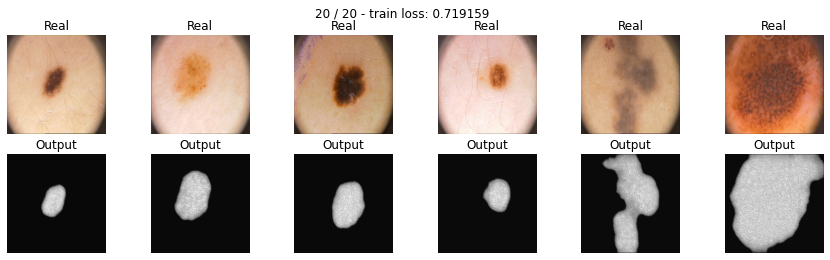

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 20
dice_optim = optim.Adam(model_dice.parameters(), lr=0.0003)
d_tr_losses, d_val_losses, d_tr_quality, d_val_quality = train(model_dice, 
                                                       dice_optim, 
                                                       dice_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.8213714003562927

In [ ]:
save_train_info("dice_segnet_log.txt", d_tr_losses, d_val_losses, d_tr_quality, 
                d_val_quality)
#save_checkpoint("/content/dice_state", segnet, optimaizer)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [30]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    sigmoid = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    first_summand = (1 - sigmoid)**gamma * y_real * torch.log(sigmoid)
    snd_summand = (1 - y_real) * torch.log(1 - sigmoid)

    return -torch.mean(first_summand + snd_summand)

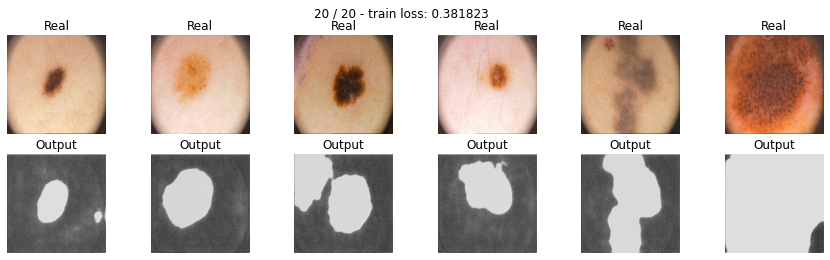

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
focal_optim = optim.Adam(model_focal.parameters(), lr=0.0003)
f_tr_losses, f_val_losses, f_tr_quality, f_val_quality = train(model_focal, 
                                                       focal_optim, 
                                                       focal_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [115]:
score_model(model_focal, iou_pytorch, data_ts)

0.6750017166137695

In [ ]:
save_train_info("focal_segnet_log.txt", f_tr_losses, f_val_losses, f_tr_quality, 
                f_val_quality)
#save_checkpoint("/content/focal_state", model_focal, optimaizer)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

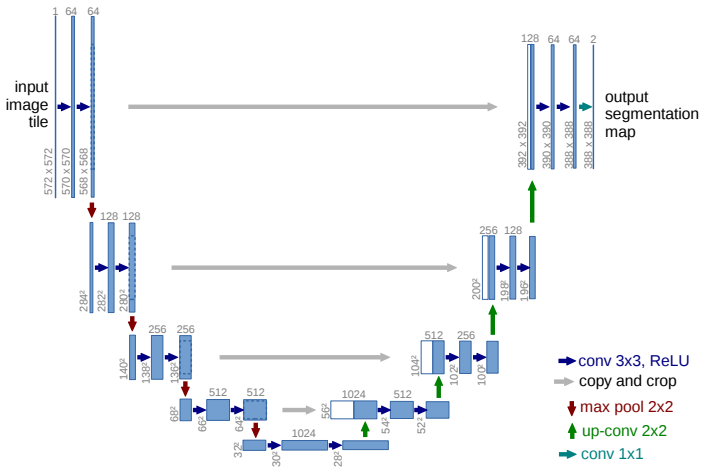

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

In [36]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 
        )
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 
        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 
        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True), 
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
        )
        # decoder (upsampling)
        self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, 
                      stride=1, padding=1), 
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 
        )

        self.upsample0 = nn.UpsamplingNearest2d(scale_factor=2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d3 = torch.cat((e3, self.upsample3(b)), dim=1)
        d3 = self.dec_conv3(d3)
        d2 = torch.cat((e2, self.upsample2(d3)), dim=1)
        d2 = self.dec_conv2(d2)
        d1 = torch.cat((e1, self.upsample1(d2)), dim=1)
        d1 = self.dec_conv1(d1)
        d0 = torch.cat((e0, self.upsample0(d1)), dim=1)
        d0 = self.dec_conv0(d0)
        return d0

In [37]:
bce_unet_model = UNet().to(device)
summary(bce_unet_model, input_size=(3, 256, 256), batch_size=10, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 256, 256]           1,792
         LeakyReLU-2         [10, 64, 256, 256]               0
            Conv2d-3         [10, 64, 256, 256]          36,928
         LeakyReLU-4         [10, 64, 256, 256]               0
         MaxPool2d-5         [10, 64, 128, 128]               0
            Conv2d-6        [10, 128, 128, 128]          73,856
         LeakyReLU-7        [10, 128, 128, 128]               0
            Conv2d-8        [10, 128, 128, 128]         147,584
         LeakyReLU-9        [10, 128, 128, 128]               0
        MaxPool2d-10          [10, 128, 64, 64]               0
           Conv2d-11          [10, 256, 64, 64]         295,168
        LeakyReLU-12          [10, 256, 64, 64]               0
           Conv2d-13          [10, 256, 64, 64]         590,080
        LeakyReLU-14          [10, 256,

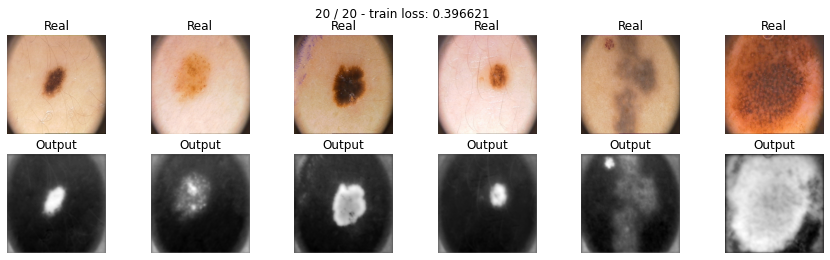

In [ ]:
max_epochs = 20
unet_optim = optim.Adam(bce_unet_model.parameters(), lr=0.0003)
u_tr_losses, u_val_losses, u_tr_quality, u_val_quality = train(bce_unet_model, 
                                                       unet_optim, 
                                                       bce_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
score_model(bce_unet_model, iou_pytorch, data_ts)

0.609727555513382

In [ ]:
save_train_info("bce_unet_log.txt", u_tr_losses, u_val_losses, u_tr_quality, 
                u_val_quality)
#save_checkpoint("/content/unet_state", unet_model, optim.Adam(unet_model.parameters()))

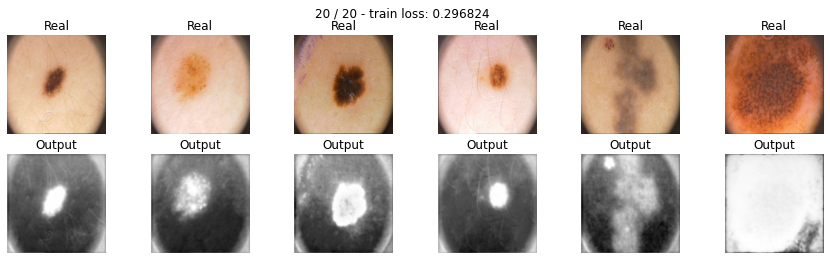

In [ ]:
max_epochs = 20
focal_unet_model = UNet().to(device)
focal_unet_optim = optim.Adam(focal_unet_model.parameters(), lr=0.0003)
u_tr_losses, u_val_losses, u_tr_quality, u_val_quality = train(focal_unet_model, 
                                                       focal_unet_optim, 
                                                       focal_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
print(score_model(focal_unet_model, iou_pytorch, data_ts))
save_train_info("focal_unet_log.txt", u_tr_losses, u_val_losses, u_tr_quality, 
                u_val_quality)
#save_checkpoint("/content/unet_state", unet_model, optim.Adam(unet_model.parameters()))

0.6540344476699829


Новая модель путем изменения типа пулинга:

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [62]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, 
                               kernel_size=2, stride=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, 
                               kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, 
                               kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, 
                               kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
        )
        # decoder (upsampling)
        self.upsample3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 
        )

        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, 
                      stride=1, padding=1), 
            nn.ReLU(inplace=True), 
        )

        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 
        )

        self.upsample0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True), 

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, 
                      padding=1), 
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d3 = torch.cat((e3, self.upsample3(b)), dim=1)
        d3 = self.dec_conv3(d3)
        d2 = torch.cat((e2, self.upsample2(d3)), dim=1)
        d2 = self.dec_conv2(d2)
        d1 = torch.cat((e1, self.upsample1(d2)), dim=1)
        d1 = self.dec_conv1(d1)
        d0 = torch.cat((e0, self.upsample0(d1)), dim=1)
        d0 = self.dec_conv0(d0)
        return d0

In [ ]:
unet2_model = UNet2().to(device)
summary(unet2_model, (3, 256, 256), batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 256, 256]           1,792
              ReLU-2         [10, 64, 256, 256]               0
            Conv2d-3         [10, 64, 256, 256]          36,928
              ReLU-4         [10, 64, 256, 256]               0
            Conv2d-5         [10, 64, 128, 128]          16,448
            Conv2d-6        [10, 128, 128, 128]          73,856
              ReLU-7        [10, 128, 128, 128]               0
            Conv2d-8        [10, 128, 128, 128]         147,584
              ReLU-9        [10, 128, 128, 128]               0
           Conv2d-10          [10, 128, 64, 64]          65,664
           Conv2d-11          [10, 256, 64, 64]         295,168
             ReLU-12          [10, 256, 64, 64]               0
           Conv2d-13          [10, 256, 64, 64]         590,080
             ReLU-14          [10, 256,

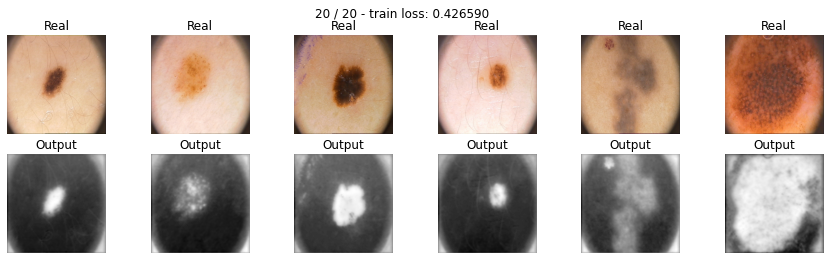

In [ ]:
max_epochs = 20
unet_optim = optim.Adam(unet2_model.parameters(), lr=0.0003)
u_tr_losses, u_val_losses, u_tr_quality, u_val_quality = train(unet2_model, 
                                                       unet_optim, 
                                                       bce_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
print(score_model(unet2_model, iou_pytorch, data_ts))
save_train_info("bce_unet2_log.txt", u_tr_losses, u_val_losses, u_tr_quality, 
                u_val_quality)

0.5322468519210816


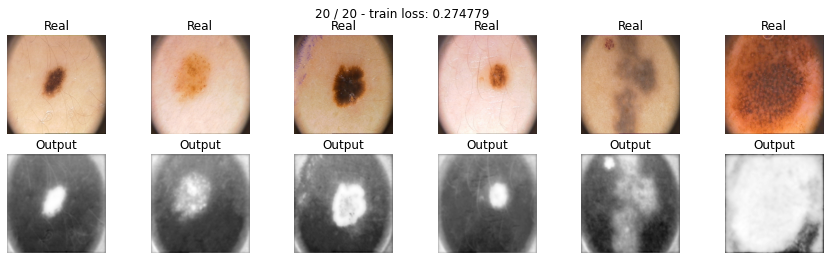

In [ ]:
max_epochs = 20
focal_unet2_model = UNet2().to(device)
focal_unet2_optim = optim.Adam(focal_unet2_model.parameters(), lr=0.0003)
u_tr_losses, u_val_losses, u_tr_quality, u_val_quality = train(focal_unet2_model, 
                                                       focal_unet2_optim, 
                                                       focal_loss, 
                                                       max_epochs, 
                                                       data_tr, 
                                                       data_val, 
                                                       verbose=True)

In [ ]:
print(score_model(focal_unet2_model, iou_pytorch, data_ts))
save_train_info("focal_unet2_log.txt", u_tr_losses, u_val_losses, u_tr_quality, 
                u_val_quality)

0.6222137689590455


Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

**Замечание:** Трюк с удвоением loss-а на валидации связан с его неправильным вычислением в процессе обучения, вызванным опечаткой: производилось деление валидационного лосса по батчу на размер обучающего даталоадера (10), а не на размер валидационного даталоадера (5)

In [100]:
def read_training_logs(filename):
    with open(filename, "r") as file_obj:
        data = file_obj.readlines()
        data = [data[i][:-1] for i in range(1, len(data), 2)]
        data = list(map(lambda elem: [float(num) for num in elem.split()], data))

    return data

In [101]:
bce_segnet = read_training_logs("bce_segnet_log.txt")
bce_unet = read_training_logs("bce_unet_log.txt")
bce_unet2 = raead_training_logs("bce_unet2_log.txt")
dice_segnet = read_training_logs("dice_segnet_log.txt")
focal_segnet = read_training_logs("focal_segnet_log.txt")
focal_unet2 = read_training_logs("focal_unet2_log.txt")
focal_unet = read_training_logs("focal_unet_log.txt")

**1. Лучшая модель для BCELoss**

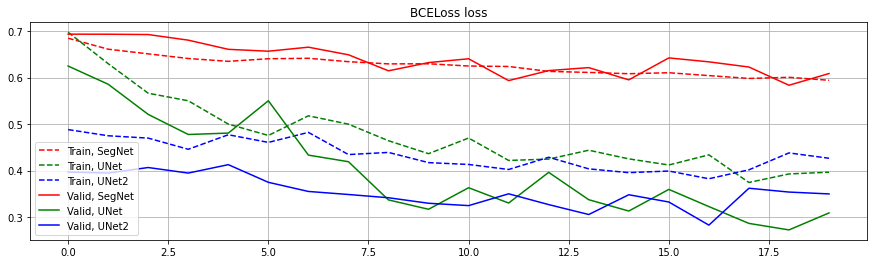

In [108]:
plt.plot(bce_segnet[0], "--", c="red", label="Train, SegNet")
plt.plot(bce_unet[0], "--", c="green", label="Train, UNet")
plt.plot(bce_unet2[0], "--", c="blue", label="Train, UNet2")

plt.plot(np.array(bce_segnet[1])*2, c="red", label="Valid, SegNet")
plt.plot(np.array(bce_unet[1])*2, c="green", label="Valid, UNet")
plt.plot(np.array(bce_unet2[1])*2, c="blue", label="Valid, UNet2")

plt.title("BCELoss loss")
plt.grid(True)
plt.legend()
plt.show()

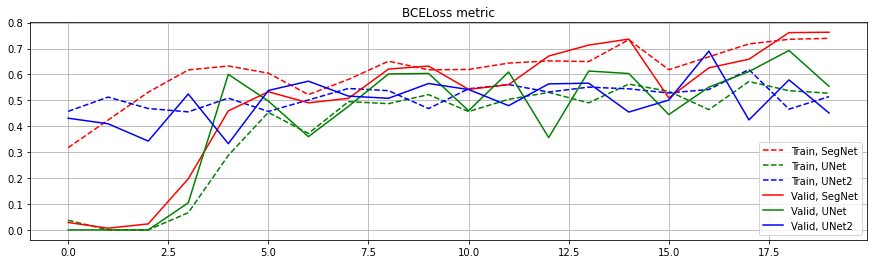

In [109]:
plt.plot(bce_segnet[2], "--", c="red", label="Train, SegNet")
plt.plot(bce_unet[2], "--", c="green", label="Train, UNet")
plt.plot(bce_unet2[2], "--", c="blue", label="Train, UNet2")

plt.plot(bce_segnet[3], c="red", label="Valid, SegNet")
plt.plot(bce_unet[3], c="green", label="Valid, UNet")
plt.plot(bce_unet2[3], c="blue", label="Valid, UNet2")

plt.title("BCELoss metric")
plt.grid(True)
plt.legend()
plt.show()

**Итог:** Несмотря на самый высокий loss, у SegNet оказалось самое высокое значение метрики на валидации 

**2. Лучшая модель для Focal Loss**

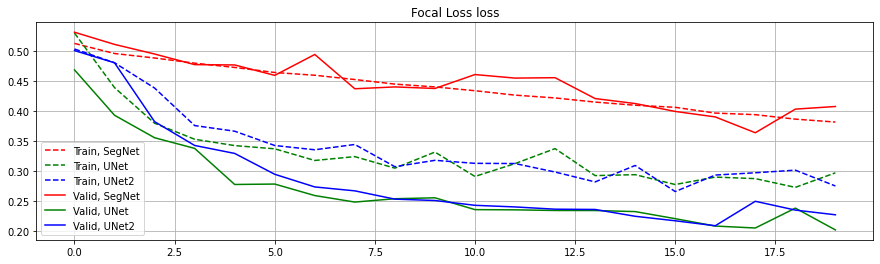

In [110]:
plt.plot(focal_segnet[0], "--", c="red", label="Train, SegNet")
plt.plot(focal_unet[0], "--", c="green", label="Train, UNet")
plt.plot(focal_unet2[0], "--", c="blue", label="Train, UNet2")

plt.plot(np.array(focal_segnet[1])*2, c="red", label="Valid, SegNet")
plt.plot(np.array(focal_unet[1])*2, c="green", label="Valid, UNet")
plt.plot(np.array(focal_unet2[1])*2, c="blue", label="Valid, UNet2")

plt.title("Focal Loss loss")
plt.grid(True)
plt.legend()
plt.show()

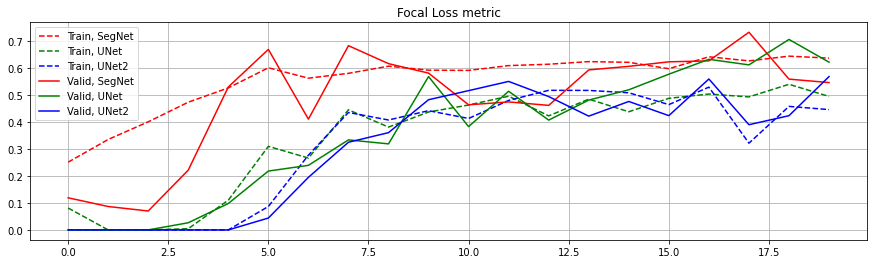

In [111]:
plt.plot(focal_segnet[2], "--", c="red", label="Train, SegNet")
plt.plot(focal_unet[2], "--", c="green", label="Train, UNet")
plt.plot(focal_unet2[2], "--", c="blue", label="Train, UNet2")

plt.plot(focal_segnet[3], c="red", label="Valid, SegNet")
plt.plot(focal_unet[3], c="green", label="Valid, UNet")
plt.plot(focal_unet2[3], c="blue", label="Valid, UNet2")

plt.title("Focal Loss metric")
plt.grid(True)
plt.legend()
plt.show()

**Итог:** Лучшее качество показала UNet

**3. Лучшая модель для Dice Loss**  

Увы, UNet и UNet2 не обучались с данной функцией потерь: начиная с 3ей эпохи loss никак не менялся. Причину этой проблемы мне найти не удалось(((

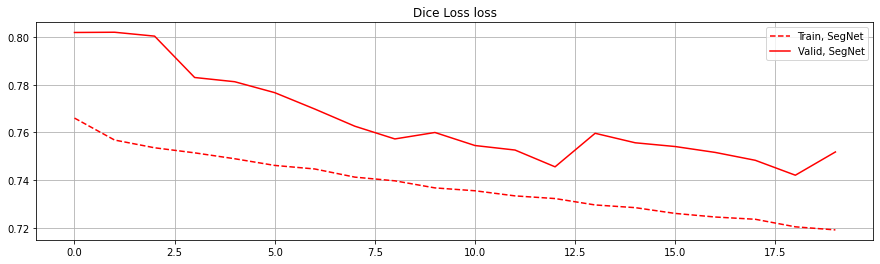

In [112]:
plt.plot(dice_segnet[0], "--", c="red", label="Train, SegNet")
plt.plot(np.array(dice_segnet[1])*2, c="red", label="Valid, SegNet")

plt.title("Dice Loss loss")
plt.grid(True)
plt.legend()
plt.show()

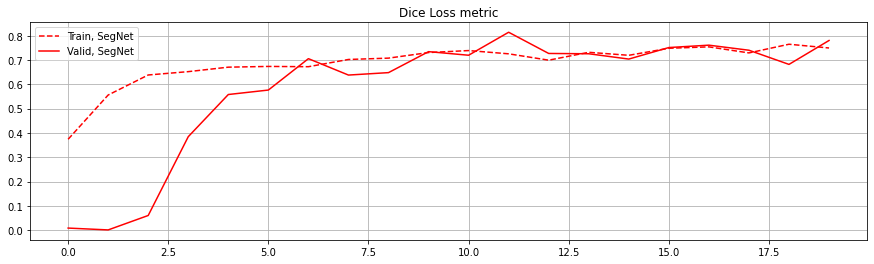

In [113]:
plt.plot(dice_segnet[2], "--", c="red", label="Train, SegNet")
plt.plot(dice_segnet[3], c="red", label="Valid, SegNet")

plt.title("Dice Loss metric")
plt.grid(True)
plt.legend()
plt.show()

**5. Лучший loss для SegNet**

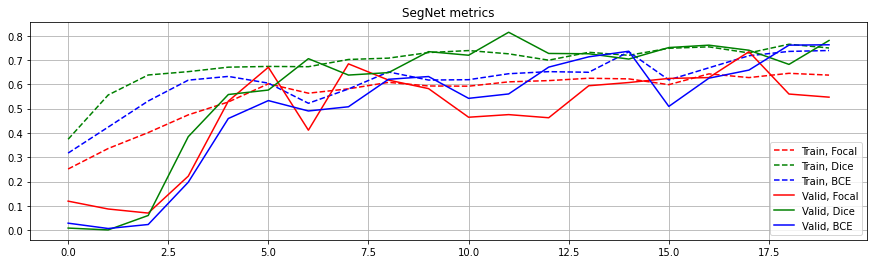

In [123]:
plt.plot(focal_segnet[2], "--", c="red", label="Train, Focal")
plt.plot(dice_segnet[2], "--", c="green", label="Train, Dice")
plt.plot(bce_segnet[2], "--", c="blue", label="Train, BCE")

plt.plot(focal_segnet[3], c="red", label="Valid, Focal")
plt.plot(dice_segnet[3], c="green", label="Valid, Dice")
plt.plot(bce_segnet[3], c="blue", label="Valid, BCE")

plt.title("SegNet metrics")
plt.grid(True)
plt.legend()
plt.show()

**Итог:** Лучшие показатели качества на валидации у Dice loss и BCELoss

**6. Лучший loss для UNet**

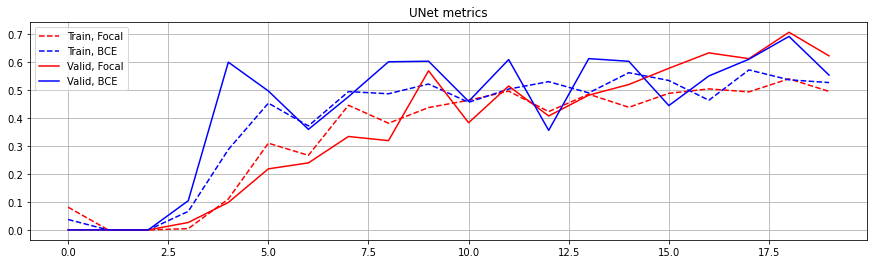

In [124]:
plt.plot(focal_unet[2], "--", c="red", label="Train, Focal")
plt.plot(bce_unet[2], "--", c="blue", label="Train, BCE")

plt.plot(focal_unet[3], c="red", label="Valid, Focal")
plt.plot(bce_unet[3], c="blue", label="Valid, BCE")

plt.title("UNet metrics")
plt.grid(True)
plt.legend()
plt.show()

**Итог:** Лучшие показатели качества на валидации у Focal loss

**7. Лучший loss для UNet2**

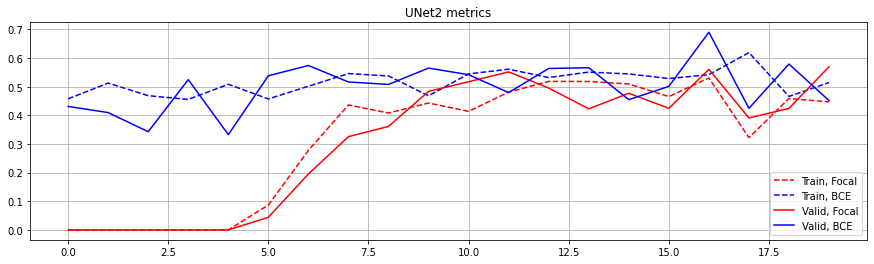

In [125]:
plt.plot(focal_unet2[2], "--", c="red", label="Train, Focal")
plt.plot(bce_unet2[2], "--", c="blue", label="Train, BCE")

plt.plot(focal_unet2[3], c="red", label="Valid, Focal")
plt.plot(bce_unet2[3], c="blue", label="Valid, BCE")

plt.title("UNet2 metrics")
plt.grid(True)
plt.legend()
plt.show()

**Итог:** Лучшие показатели качества на валидации у Focal loss

**8. Лучшие показатели на тестовом датасете**  
BCE SegNet: 0.781  
**Dice SegNet:** 0.821  
Focal SegNet: 0.675  
BCE UNet: 0.61  
Focal UNet: 0.654  
BCE UNet2: 0.532  
Focal UNet2: 0.622  

В принципе, это было ожидаемо, поскольку Dice Loss сильно похож на метрику IoU